once again path finding...

On a single position we can have at max 4 different blizzards, each moving 
in a different direction. There can never be e.g. two right moving 
blizzards at the same position. This is because in the starting map
we do not have such a situation.

I will code the four types as powers of two.

In [11]:
import numpy as np

In [25]:
blizzards = {
    ".": 0,
    "^": 2**0,
    "<": 2**1,
    "v": 2**2,
    ">": 2**3
}

blizzards

{'.': 0, '^': 1, '<': 2, 'v': 4, '>': 8}

In [95]:
def read_input(file_name):
    with open(file_name) as f:
        rows = []
        for line in f.readlines():
            line = line.strip()
            if line.startswith("#.#") or line.startswith("#E#"):
                # start line
                continue
            elif line.startswith("###"):
                # endline
                break
            rows.append(np.array([blizzards[c] for c in line[1:-1]]))
    return np.array(rows)

In [96]:
m = read_input("example")

In [97]:
m

array([[8, 8, 0, 2, 1, 2],
       [0, 2, 0, 0, 2, 2],
       [8, 4, 0, 8, 2, 8],
       [2, 1, 4, 1, 1, 8]])

In [98]:
m & 8

array([[8, 8, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [8, 0, 0, 8, 0, 8],
       [0, 0, 0, 0, 0, 8]])

In [99]:
bm = np.pad(m, 1, mode='constant')
np.roll(bm, -1, axis=1), bm

(array([[0, 0, 0, 0, 0, 0, 0, 0],
        [8, 8, 0, 2, 1, 2, 0, 0],
        [0, 2, 0, 0, 2, 2, 0, 0],
        [8, 4, 0, 8, 2, 8, 0, 0],
        [2, 1, 4, 1, 1, 8, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 8, 8, 0, 2, 1, 2, 0],
        [0, 0, 2, 0, 0, 2, 2, 0],
        [0, 8, 4, 0, 8, 2, 8, 0],
        [0, 2, 1, 4, 1, 1, 8, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]))

In [103]:
def move_blizzards(m):
    res = []
    for d in range(4):
        bm = m & (2**d)
        bm = np.pad(bm, 1, mode='constant')
        if d == 0:
            # up
            res.append(np.roll(bm, -1, axis=0))
        elif d == 1:
            # left
            res.append(np.roll(bm, -1, axis=1))       
        elif d == 2:
            # down
            res.append(np.roll(bm, 1, axis=0))
        else:
            # right
            res.append(np.roll(bm, 1, axis=1))
    bm = np.sum(res, axis=0)
    # let blizzards who leave the map enter at the opposite side
    # Because I am lazy, I will hardcode this
    uw, lw, dw, rw = bm[0][1:-1], bm[:,0][1:-1], bm[-1][1:-1], bm[:,-1][1:-1]
    bm[-2][1:-1] += uw
    bm[1][1:-1] += dw
    bm[:,-2][1:-1] += lw
    bm[:,1][1:-1] += rw
    return bm[1:-1, 1:-1]

In [104]:
bm = move_blizzards(m)
bm

array([[ 0,  8, 14,  0,  2,  0],
       [ 2,  0,  0,  2,  2,  0],
       [ 8,  9,  0,  3,  9,  0],
       [ 8,  4,  0,  0,  1,  2]])

In [105]:
bm = move_blizzards(bm)
bm

array([[ 0,  6,  8, 10,  0,  0],
       [ 0,  1,  6,  3,  1,  2],
       [ 0,  8, 10,  0,  1,  8],
       [ 0,  8,  0,  0,  2,  0]])

In [106]:
bm = move_blizzards(bm)
bm

array([[ 2,  1,  2,  9,  9,  0],
       [ 0,  6,  2,  0,  3,  0],
       [ 8,  2, 12,  8,  0,  0],
       [ 0,  0,  8,  2,  0,  0]])

The pattern of the blizzards will repeat with a period $T$, because there
is not interaction. This period will be the *Least common multiple*
of the height and th width of the map.

In the example we have $h=4$ and $w=6$, so the lcm is $T=12$. 

Initial state:

    #E######
    #>>.<^<#
    #.<..<<#
    #>v.><>#
    #<^v^^>#
    ######.#

Minute 12, move down:

    #.######
    #>>.<^<#
    #.<E.<<#
    #>v.><>#
    #<^v^^>#
    ######.#

Both configurations are the same.

We can use this for pruning: If the position of E is the same after the 
period $p_E(t + T) = p_E(t)$ we can discard this branch of the search tree.

In [108]:
m = read_input("input")

In [110]:
m.shape

(35, 100)

In [111]:
import math

In [112]:
math.lcm(35, 100)

700

That is not really helpful. Maybe we can find a shorter period by looking at
the map?

In [118]:
confs = set()
confs.add(m.tobytes())

In [119]:
confs

{b'\x08\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x01\

In [136]:
confs = set()
bm = np.copy(m)
for i in range(701):
    bm = move_blizzards(bm)
    s = bm.tobytes()
    if s in confs:
        print("found!", i)
        break
    confs.add(s)

found! 700


Nope. It only repeats after the full period.

In [137]:
import matplotlib.pyplot as plt

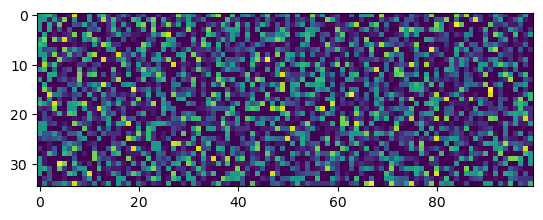

In [138]:
plt.imshow(bm)

Ok, then I will try the naive approach. Just let's hope that there
are not too many possible next positions each step!

In [156]:
from matplotlib import animation

class BlizzardAnimation:
    def __init__(self, bm, frames, cmap='gnuplot', figsize=(6,14)):
        self.fig = plt.figure(figsize=figsize)
        self.ax1 = ax1 = plt.subplot(1,1,1)
        self.cmap = cmap
        # Init with an inner image! Otherwise the colormap is wrong.
        inner = move_blizzards(move_blizzards(bm))
        self.image = ax1.imshow(inner, origin='upper', cmap=cmap, aspect='equal')
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)
        self.bm = bm
        self.frames = frames

    def init_anmimation(self):
        self.image.set_data(self.bm)
        return self.image,

    def get_frame(self, i):
        self.bm = move_blizzards(self.bm)
        self.image.set_data(self.bm)
        return self.image,
    
    def animation(self):
        anim = animation.FuncAnimation(self.fig, self.get_frame, init_func=self.init_anmimation,
                                       frames=self.frames, interval=50, blit=True)
        return anim
    
    def save_mp4(self, filename):
        ffwriter = animation.FFMpegWriter(fps=24, extra_args=['-vcodec', 'libx264'])
        anim = self.animation()
        anim.save(filename, dpi=300, writer=ffwriter)
        plt.close()   # to prevent the last frame from showing in notebook

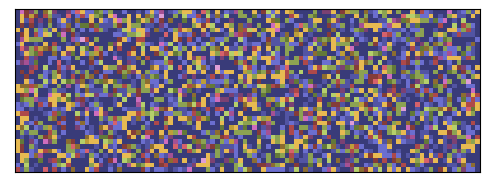

In [161]:
anim = BlizzardAnimation(np.copy(m), range(701), cmap='tab20b')

In [163]:
anim.save_mp4("test.mp4")

In [252]:
def move_expedition(m):
    res = []
    for d in range(5):
        bm = np.copy(m)
        bm = np.pad(bm, 1, mode='constant')
        if d == 0:
            # up
            res.append(np.roll(bm, -1, axis=0))
        elif d == 1:
            # left
            res.append(np.roll(bm, -1, axis=1))       
        elif d == 2:
            # down
            res.append(np.roll(bm, 1, axis=0))
        elif d == 3:
            # right
            res.append(np.roll(bm, 1, axis=1))
        else:
            # wait
            res.append(bm)

    bm = np.sum(res, axis=0)

    # remove the extra padding
    bm = bm[1:-1, 1:-1]
    # clear everything on the walls except the entry and exit
    bm[0][2:] = 0
    bm[:,-1] = 0
    bm[-1, :-2] = 0
    bm[:,0] = 0 
    
    # normalize the values
    bm[bm != 0] = 1
    return bm

In [253]:
m = read_input("example")

In [254]:
def make_expd_map(blzzd_map):
    em = np.pad(np.zeros_like(blzzd_map), 1, mode='constant')
    em[0][1] = 1
    return em

In [255]:
def complete_step(two_maps):
    blzzrd_map, expd_map = two_maps
    blzzrd_map = move_blizzards(blzzrd_map)
    expd_map = move_expedition(expd_map)
    mask = np.pad(blzzrd_map, 1, mode='constant') != 0
    expd_map[mask] = 0
    return (blzzrd_map, expd_map)

In [290]:
em = make_expd_map(m)
s = (m, em)

In [287]:
bm , em = s = complete_step(s)

In [288]:
em

array([[0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [295]:
def cross_map(em, max_step=100_000):
    em = make_expd_map(m)
    s = (m, em)    
    for i in range(max_step):
        print(i)
        bm , em = s = complete_step(s)
        if em[-1][-2] == 1:
            print("reached!")
            break
    return s

In [296]:
s = cross_map(m)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
reached!


In [297]:
bm, em = s

In [299]:
bm

array([[ 8, 12,  0,  2,  0,  2],
       [ 0,  3,  4,  1,  3,  2],
       [ 8,  0,  0,  8,  3,  8],
       [ 2,  0,  0,  0,  0,  8]])

In [300]:
m = read_input("input")

In [302]:
s = cross_map(m)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
reached!


# Part 2

In [325]:
def criss_cross_map(s, target=(-1, -2), max_step=100_000):
    for i in range(max_step):
        if i+1 % 50 == 0:
            print(i)
        bm , em = s = complete_step(s)
        if em[target[0]][target[1]] == 1:
            break
    return s, i

In [326]:
def part2(em):
    em = make_expd_map(m)
    s = (m, em)    
    s1, i1 = criss_cross_map(s)
    print("First round", i1+1)
    # clear everything but the elf at the end
    bm, em = s1
    em = np.zeros_like(em)
    em[-1][-2] = 1
    s2, i2 = criss_cross_map((bm, em), target=(0,1))
    print("back in", i2+1)
    # start again!
    bm, em = s2
    em = np.zeros_like(em)
    em[0][1] = 1    
    s3, i3 = criss_cross_map((bm, em))
    print("Second round", i3+1)
    print("Altogether:", i1+i2+i3+3)

In [327]:
m = read_input("example")
part2(m)

First round 18
back in 23
Second round 13
Altogether: 54


In [328]:
m = read_input("input")
part2(m)

First round 228
back in 241
Second round 254
Altogether: 723
